<a href="https://colab.research.google.com/github/zdanielshi/data_science_LFZ/blob/main/DS_0628_Kaggle_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [828]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("error")

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from google.colab import drive

In [829]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [830]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test.csv')

In [831]:
train.shape

(1460, 81)

In [832]:
test.shape

(1459, 80)

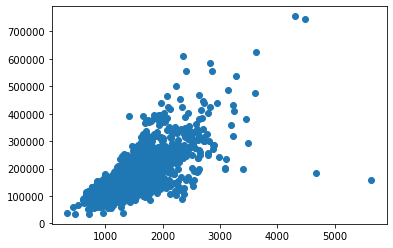

In [833]:
plt.scatter(train.GrLivArea, train.SalePrice)

In [834]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [835]:
train.shape

(1458, 81)

# Stacking the two tables
Also separating out price feature into it's own column

In [836]:
y = pd.DataFrame(train['SalePrice'])

In [837]:
y.describe()

,SalePrice
count,1458.00000
mean,180932.91907
std,79495.05528
min,34900.00000
25%,129925.00000
50%,163000.00000
75%,214000.00000
max,755000.00000


In [838]:
# train.drop(columns = 'SalePrice', inplace=True)

In [839]:
x = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)

In [840]:
x

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.00000,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.00000,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.00000,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.00000,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


Plan of attack
* Analysis
* Clean up
  * Nulls
  * Outlier values
* Feature engineering
* Numericals to categoricals
* Ordinals
* Do some correlation and pairplotting
* Drop columns
  * Use the xnum threshold method
* Preprocessing
  * Transforming
  * Scaling
  * Encoding
* Regression and analysis

# Analysis

In [841]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2917 non-null   int64  
 1   MSSubClass     2917 non-null   int64  
 2   MSZoning       2913 non-null   object 
 3   LotFrontage    2431 non-null   float64
 4   LotArea        2917 non-null   int64  
 5   Street         2917 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2917 non-null   object 
 8   LandContour    2917 non-null   object 
 9   Utilities      2915 non-null   object 
 10  LotConfig      2917 non-null   object 
 11  LandSlope      2917 non-null   object 
 12  Neighborhood   2917 non-null   object 
 13  Condition1     2917 non-null   object 
 14  Condition2     2917 non-null   object 
 15  BldgType       2917 non-null   object 
 16  HouseStyle     2917 non-null   object 
 17  OverallQual    2917 non-null   int64  
 18  OverallC

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc924e00410>]],
      dtype=object)

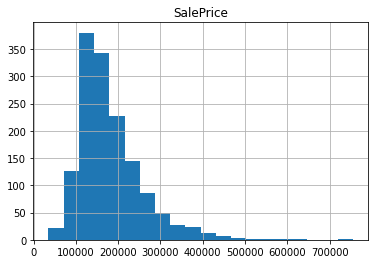

In [842]:
y.hist(bins = 20)

Correlations

In [843]:
# plt.figure(figsize =(30,10))
# heatmap = sns.heatmap(train.corr(), annot=True, vmin = -1, vmax = 1, cmap = 'BrBG')

## Clean up

#### Clean up columns where nulls = 'none'

* PoolQC - 'No pool'
* Fence - 'No fence'
* MiscFeature - 'No feature'
* Alley - 'No alley'
* BsmtQual - 'No basement'
* BsmtCond - 'No basement'
* BsmtExposure - 'No basement'
* BsmtFinType1 - 'No basement'
* BsmtFinType2 - 'No basement'
* FireplaceQu - 'No fireplace'
* GarageType - 'No garage'
* GarageYrBlt - 'No garage'
* GarageQual - 'No garage'
* GarageCond - 'No garage'


In [844]:
x.isnull().sum().sum()

13958

In [845]:
x.PoolQC.fillna('Not present', inplace=True) # PoolQC 
x.Fence.fillna('Not present', inplace=True) # Fence
x.MiscFeature.fillna('Not present', inplace=True) # MiscFeature
x.Alley.fillna('Not present', inplace=True) # Alley
x.BsmtQual.fillna('Not present', inplace=True) # BsmtQual
x.BsmtCond.fillna('Not present', inplace=True) # BsmtCond
x.BsmtExposure.fillna('Not present', inplace=True) # BsmtExposure
x.BsmtFinType1.fillna('Not present', inplace=True) # BsmtFinType1
x.BsmtFinType2.fillna('Not present', inplace=True) # BsmtFinType2
x.FireplaceQu.fillna('Not present', inplace=True) # FireplaceQu
x.GarageType.fillna('Not present', inplace=True) # GarageType
x.GarageYrBlt.fillna('Not present', inplace=True) # GarageYrBlt
x.GarageQual.fillna('Not present', inplace=True) # GarageQual
x.GarageCond.fillna('Not present', inplace=True) # GarageCond
x.GarageFinish.fillna('Not present', inplace=True) # GarageFinish

In [846]:
x.isnull().sum().sum()

556

### Filling in nulls

In [847]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

LotFrontage     486
MasVnrType       24
MasVnrArea       23
MSZoning          4
BsmtFullBath      2
BsmtHalfBath      2
Functional        2
Utilities         2
BsmtFinSF1        1
Exterior2nd       1
BsmtFinSF2        1
KitchenQual       1
GarageArea        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
GarageCars        1
Exterior1st       1
SaleType          1
dtype: int64

In [848]:
isnull_under_100 = isnull[isnull < 100]
list_isnull_under_100 = isnull_under_100.index.tolist()

list_isnull_under_100

['MasVnrType',
 'MasVnrArea',
 'MSZoning',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Functional',
 'Utilities',
 'BsmtFinSF1',
 'Exterior2nd',
 'BsmtFinSF2',
 'KitchenQual',
 'GarageArea',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'GarageCars',
 'Exterior1st',
 'SaleType']

In [849]:
for i in list_isnull_under_100:
  try:
    x[i].fillna(x[i].median()[0], inplace=True)
  except:
    x[i].fillna(x[i].mode()[0], inplace=True)

In [850]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

LotFrontage    486
dtype: int64

In [851]:
x.groupby('LotConfig')['LotFrontage'].median()

LotConfig
Corner    80.00000
CulDSac   50.00000
FR2       62.00000
FR3       66.00000
Inside    66.00000
Name: LotFrontage, dtype: float64

In [852]:
x.LotFrontage.fillna(x.groupby('LotConfig')['LotFrontage'].transform('median'),inplace=True)

In [853]:
isnull = x.isnull().sum().sort_values(ascending=False)
isnull = isnull[isnull > 0]
isnull

Series([], dtype: int64)

### Looking for outliers

### Fix some categoricals
* CentralAir: make it 1 and 0

In [854]:
x['CentralAir'] = x['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [855]:
x['CentralAir'] = x['CentralAir'].astype('object')

# Feature Engineering

#### Features to engineer
1. Total square footage (sum all of the sq fts)
1.  Total # of bathrooms
1.  Total porch sq
1.  Does it have a pool?
1.  Does it have a 2nd floor?
1. Does it have a garage
1. Does it have a basement?
1. Does it have a fireplace?

In [856]:
# Total square footage
x['TotalLivableSF'] = x['1stFlrSF'] + x['2ndFlrSF'] + x['BsmtFinSF1'] + x['BsmtFinSF2']

In [857]:
# Total # of bathrooms
x['TotalBaths'] = x['BsmtFullBath'] + (x['BsmtHalfBath'] * .5) + x['FullBath'] + (x['HalfBath'] * .5)

In [858]:
# Total porch square footage
x["TotalPorchSF"] = x.WoodDeckSF + x.OpenPorchSF + x.EnclosedPorch + x['3SsnPorch']

In [859]:
# Does it have a pool (2906)
x['HasPool'] = x['PoolArea'].apply(lambda x: 1 if x >0 else 0).astype('category')

In [860]:
# Does it have a 2nd floor
x['Has2ndFloor'] = x['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [861]:
# Does it have a garage
x['HasGarage'] = x['GarageArea'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [862]:
# Does it have a basement
x['HasBasement'] = x['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).astype('category')

In [863]:
# Does it have a fireplace?
x['HasFireplace'] = x['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).astype('category')

# Preprocessing

## Changing objects to numericals

In [864]:
xcat = x.select_dtypes(include='object')

## Changing quality values to numbers
* These are features with "Ex, Gd, TA, FA, PO, NA"
  * ExterQual
  * ExterCond
  * BsmtQual
  * BsmtCond
  * HeatingQC
  * KitchenQual
  * FireplaceQu
  * GarageQual
  * GarageCond
  * PoolQC
* These have "GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA"
  * BsmtFinType1
  * BsmtFinType2
* Functional Deduction


In [865]:
# # Changing all of the columns with "Ex, Gd, TA, FA, PO, NA"
# qual_dict = {
#             "Ex": '6',
#             "Gd": '5',
#             "TA": '4',
#             "Fa": '3',
#             "Po": '2', 
#             "Not present": '1'
#             }

# x.replace({'ExterQual': qual_dict}, inplace=True)
# x.replace({'ExterCond': qual_dict}, inplace=True)
# x.replace({'BsmtQual': qual_dict}, inplace=True)
# x.replace({'BsmtCond': qual_dict}, inplace=True)
# x.replace({'HeatingQC': qual_dict}, inplace=True)
# x.replace({'KitchenQual': qual_dict}, inplace=True)
# x.replace({'FireplaceQu': qual_dict}, inplace=True)
# x.replace({'GarageQual': qual_dict}, inplace=True)
# x.replace({'GarageCond': qual_dict}, inplace=True)
# x.replace({'PoolQC': qual_dict}, inplace=True)

# x.ExterQual = x.ExterQual.astype('int')
# x.ExterCond = x.ExterCond.astype('int')
# x.BsmtQual = x.BsmtQual.astype('int')
# x.BsmtCond = x.BsmtCond.astype('int')
# x.HeatingQC = x.HeatingQC.astype('int')
# x.KitchenQual = x.KitchenQual.astype('int')
# x.FireplaceQu = x.FireplaceQu.astype('int')
# x.GarageQual = x.GarageQual.astype('int')
# x.GarageCond = x.GarageCond.astype('int')
# x.PoolQC = x.PoolQC.astype('int')

In [866]:
# # Changing the Basement Finishes
# fin_dict = {
#             "GLQ":'7',
#             "ALQ":'6',
#             "BLQ":'5',
#             "Rec":'4',
#             "LwQ":'3',
#             "Unf":'2',
#             "Not present":'1'
#             }

# x.replace({'BsmtFinType1': fin_dict}, inplace=True)
# x.replace({'BsmtFinType2': fin_dict}, inplace=True)

# x.BsmtFinType1 = x.BsmtFinType1.astype('int')
# x.BsmtFinType2 = x.BsmtFinType2.astype('int')

In [867]:
# # Change basement exposure
# exp_dict = {
#             "Gd":'5',
#             "Av":'4',
#             "Mn":'3',
#             "No":'2',
#             "Not present":'1'
#             }

# x.replace({'BsmtExposure': exp_dict}, inplace=True)

# x.BsmtExposure = x.BsmtExposure.astype('int')

In [868]:
# Functional category
# func_dict = {
#             "Typ":'8',
#             "Min1":'7',
#             "Min2":'6',
#             "Mod":'5',
#             "Maj1":'4',
#             "Maj2":'3',
#             "Sev":'2',
#             "Sal":'1'
#             }

# x.replace({'Functional': func_dict}, inplace=True)
# x.Functional = x.Functional.astype('int')

## Changing numericals to objects
* Change MSSubClass to categoricals. The numbers are codes, not ordered.
* Change YrSold and MoSold. Those aren't ordered


In [869]:
xnum = x.select_dtypes(include = 'number')

In [870]:
# Changing MSSubClass to categoricals
x['MSSubClass'] = x["MSSubClass"].astype('object')

In [871]:
# Changing YrSold to categoricals
x['YrSold'] = x["YrSold"].astype('object')

In [872]:
# Changing MoSold to categoricals
x['MoSold'] = x["MoSold"].astype('object')

In [873]:
xnum = x.select_dtypes(include = 'number')

## Transforming

In [874]:
xnum_to_transform = []
skew_threshold = .5

for (xcolname, xcol) in xnum.iteritems():
  skew = xcol.skew()
  if abs(skew) > skew_threshold:
    xnum_to_transform.append(xcolname)

len(xnum_to_transform)

28

In [875]:
xnum_to_transform

['LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'TotalLivableSF',
 'TotalPorchSF']

In [876]:
xnum_transformed_skews = pd.DataFrame()

for i in xnum_to_transform:  # for loop across the xnums_to_transform
  dict = {} # create a dictionary
  try: 
    log_skew = np.log(x[i]).skew() # log transformation
  except: 
    log_skew = 999
  try: 
    sqrt_skew = np.sqrt(x[i]).skew() # sqrt transformation
  except: 
    srt_skew_skew = 999
  try:
    inverse_skew = (1/x[i]).skew() # inverse transformation
  except: 
    inverse_skew = 999
  try: 
    boxcox_skew = pd.DataFrame(list(stats.boxcox(x[i])[0])).skew()[0] # boxcox transformation
  except: 
    boxcox_skew = 999
  try:
    yj_skew = pd.DataFrame(list(stats.yeojohnson(x[i])[0])).skew()[0]# yj skew
  except: 
    yj_skew = 999
  dict['log skew'] = abs(log_skew) # append log to dict
  dict['sqrt skew'] = abs(sqrt_skew) # append sqrt to dict
  dict['inverse skew'] = abs(inverse_skew) # append inverted to dict
  dict['boxcox skew'] = abs(boxcox_skew) # append boxcox to dict
  dict['yj skew'] = abs(yj_skew) # append yj to dict
  best_skew_key = min(dict, key = dict.get)
  if best_skew_key == 'log skew':
    x[i] = np.log(x[i])
  elif best_skew_key == 'sqrt skew':
    x[i] = np.sqrt(x[i])
  elif best_skew_key == 'inverse skew':
    x[i] = (1/x[i])
  elif best_skew_key == 'boxcox skew':
    x[i] = list(stats.boxcox(x[i])[0])
  else:
    x[i] = list(stats.yeojohnson(x[i])[0])
  
  #best_skew_val = min(dict.values())
  #print(i, best_skew_key, "{:.2f}".format(best_skew_val))
  
  #print(i, best_skew) # determine which transformation had the lowest skew
  # apply that transformation to the column

In [877]:
xnum = x.select_dtypes(include = 'number')

xnum_to_transform_2 = []
skew_threshold = 0.60

for (xcolname, xcol) in xnum.iteritems():
  skew = xcol.skew()
  if abs(skew) > skew_threshold:
    xnum_to_transform_2.append(xcolname)

len(xnum_to_transform_2)

9

In [878]:
for i in xnum_to_transform_2:
  skew = x[i].skew()
  print(i, "{:2f}".format(skew))

BsmtFinSF2 2.355281
LowQualFinSF 8.367252
BsmtHalfBath 3.707631
KitchenAbvGr -2.063595
EnclosedPorch 1.883004
3SsnPorch 8.713711
ScreenPorch 2.915386
PoolArea 15.502729
MiscVal 5.038164


#### Dropping all of the high skew columns

In [879]:
x.shape

(2917, 88)

In [880]:
#Dropping all of the high skew columns
x.drop(columns=xnum_to_transform_2, inplace=True)

In [881]:
x.shape

(2917, 79)

## Transforming Y.SalePrice

In [882]:
y.skew()

SalePrice   1.88130
dtype: float64

In [883]:
y.describe()

,SalePrice
count,1458.00000
mean,180932.91907
std,79495.05528
min,34900.00000
25%,129925.00000
50%,163000.00000
75%,214000.00000
max,755000.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9245e41d0>]],
      dtype=object)

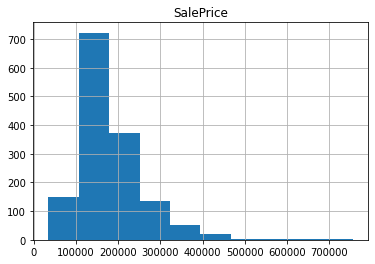

In [884]:
y.hist()

In [885]:
print('y log skew', np.log(y).skew())
print('y sqrt skew', np.sqrt(y).skew())
print('y inverse skew', (1/y).skew())
print('y YJ skew', pd.DataFrame(list(stats.yeojohnson(y))[0]).skew()[0])

y log skew SalePrice   0.12157
dtype: float64
y sqrt skew SalePrice   0.94249
dtype: float64
y inverse skew SalePrice   2.14007
dtype: float64
y YJ skew -0.008634434986093346


In [886]:
#y['SalePrice'] = np.log[(y['SalePrice'])

##### come back to this: try to do a YJ transform

In [887]:
# YJ is the best transformation. Use the PowerTransformer funciton.

# y['SalePrice'] = list(stats.yeojohnson(y))[0]
# print(y.skew())
# y.hist()

pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(y)

PowerTransformer()

In [888]:
y.SalePrice = pt.transform(y)

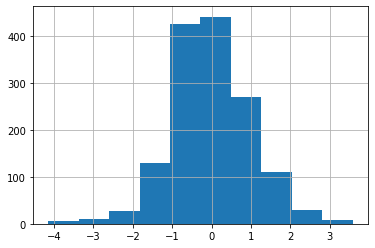

In [889]:
y.SalePrice.hist()

## Dropping columns 
* ID

In [890]:
x.shape

(2917, 79)

In [891]:
x.drop(columns = 'Id', inplace=True)

In [892]:
x.shape

(2917, 78)

## Scaling

### Identifying which columns are booleans already

In [893]:
bool_list = [] # initiate a list
for (xcolname, xcol) in x.iteritems(): # iterate through columns that
  bool_test = xcol.value_counts().index.tolist() # find the number of unique values per column
  if 1 and 0 in bool_test and len(bool_test) == 2: # if there are only 2 unique values, add them to the list
    bool_list.append(xcolname)

print(bool_list)# print the list

['CentralAir', 'HasPool', 'Has2ndFloor', 'HasGarage', 'HasBasement', 'HasFireplace']


In [894]:
for i in bool_list:
  x[i] = x[i].astype('bool')

### Selecting the columns to scale (numerics, excluding bools)

In [895]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      2917 non-null   object 
 1   MSZoning        2917 non-null   object 
 2   LotFrontage     2917 non-null   float64
 3   LotArea         2917 non-null   float64
 4   Street          2917 non-null   object 
 5   Alley           2917 non-null   object 
 6   LotShape        2917 non-null   object 
 7   LandContour     2917 non-null   object 
 8   Utilities       2917 non-null   object 
 9   LotConfig       2917 non-null   object 
 10  LandSlope       2917 non-null   object 
 11  Neighborhood    2917 non-null   object 
 12  Condition1      2917 non-null   object 
 13  Condition2      2917 non-null   object 
 14  BldgType        2917 non-null   object 
 15  HouseStyle      2917 non-null   object 
 16  OverallQual     2917 non-null   int64  
 17  OverallCond     2917 non-null   f

In [896]:
num_cols_to_scale = x.select_dtypes(exclude = ['object', 'bool']).columns.values.tolist()
num_cols_to_scale

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'TotalLivableSF',
 'TotalBaths',
 'TotalPorchSF']

### Robust Scaler

In [897]:
# robust_scaler = RobustScaler().fit(x[num_cols_to_scale])
# x[num_cols_to_scale] = robust_scaler.transform(x[num_cols_to_scale])

### Standard Scaler

In [898]:
standard_scaler = StandardScaler().fit(x[num_cols_to_scale])
x[num_cols_to_scale] = standard_scaler.transform(x[num_cols_to_scale])

### MinMax Scaler

In [899]:
# minmax_scaler = MinMaxScaler().fit(x[num_cols_to_scale])
# x[num_cols_to_scale] = minmax_scaler.transform(x[num_cols_to_scale])

## Encoding

In [900]:
cat_cols_to_encode = x.select_dtypes(include = 'object').columns.values.tolist()
cat_cols_to_encode

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [901]:
x = pd.get_dummies(x)

# Training and Predicting

## Prepping the training data and splitting it

In [902]:
total_copy = x

In [903]:
new_test = test.shape[0]
train2 = total_copy[:train.shape[0]]
test2 = total_copy[train.shape[0]:test.shape[0] + (new_test+1)]

In [904]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(train2, y.SalePrice, test_size = .33, random_state = 7)

In [905]:
print('xtrain2', xtrain2.shape)
print('xtest2', xtest2.shape)
print('ytrain2', ytrain2.shape)
print('ytest2', ytest2.shape)

xtrain2 (976, 432)
xtest2 (482, 432)
ytrain2 (976,)
ytest2 (482,)


In [906]:
ytest2 = pd.DataFrame(ytest2)

In [907]:
#untransform ytest data
ytest2_untrans = pt.inverse_transform(ytest2)

## Lasso Regression

In [908]:
#Lasso alpha optimization
model = LassoCV(cv=5, random_state=0, max_iter=10000)
model.fit(xtrain2, ytrain2)
model.alpha_

0.0017540869054382458

In [909]:
las = Lasso(alpha = model.alpha_).fit(xtrain2, ytrain2)
ypred2_las = las.predict(xtest2)
ypred2_las = pd.DataFrame(ypred2_las, columns = ['SalePrice'])
ypred2_las_untrans = pt.inverse_transform(ypred2_las)

### Analyzing the results

Mean Squared Error is 513,992,381.47
Root Mean Squared Error is 22,671.40
Mean Absolute Error is 14,427.27


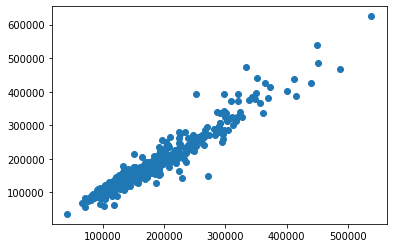

In [910]:
las_mse = mean_squared_error(ytest2_untrans, ypred2_las_untrans)
las_rmse = np.sqrt(las_mse)
las_mae = mean_absolute_error(ytest2_untrans, ypred2_las_untrans)

plt.scatter(ypred2_las_untrans, ytest2_untrans)
print('Mean Squared Error is', '{:,.2f}'.format(las_mse))
print('Root Mean Squared Error is', '{:,.2f}'.format(las_rmse))
print('Mean Absolute Error is', '{:,.2f}'.format(las_mae))

### Predicting the results using Lasso

In [911]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/test.csv')

In [912]:
submit_pred_las = las.predict(test2)
submit_pred_las = pd.DataFrame(submit_pred_las, columns = ['SalePrice'])
submit_pred_untrans_las = pt.inverse_transform(submit_pred_las)

In [913]:
test_to_submit_las = pd.DataFrame(test['Id'])
test_to_submit_las['SalePrice'] = submit_pred_untrans_las
test_to_submit_las.to_csv('/content/predictions(lasso).csv', index=False)

## Ridge Regression

In [914]:
ridge = Ridge(alpha = 10).fit(xtrain2, ytrain2)
ypred2_ridge = ridge.predict(xtest2)
ypred2_ridge = pd.DataFrame(ypred2_ridge, columns = ['SalePrice'])
ypred2_ridge_untrans = pt.inverse_transform(ypred2_ridge)

### Analyzing the results for ridge regression

Mean Squared Error is 518,214,078.74
Root Mean Squared Error is 22,764.32
Mean Absolute Error is 14,555.11


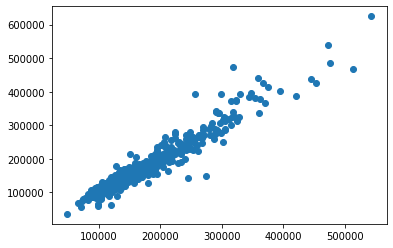

In [915]:
ridge_mse = mean_squared_error(ytest2_untrans, ypred2_ridge_untrans)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(ytest2_untrans, ypred2_ridge_untrans)

plt.scatter(ypred2_ridge_untrans, ytest2_untrans)
print('Mean Squared Error is', '{:,.2f}'.format(ridge_mse))
print('Root Mean Squared Error is', '{:,.2f}'.format(ridge_rmse))
print('Mean Absolute Error is', '{:,.2f}'.format(ridge_mae))

### Predicting the results using Ridge

In [916]:
submit_pred_ridge = ridge.predict(test2)
submit_pred_ridge = pd.DataFrame(submit_pred_ridge, columns = ['SalePrice'])
submit_pred_ridge_untrans = pt.inverse_transform(submit_pred_ridge)

In [917]:
test_to_submit_ridge = pd.DataFrame(test['Id'])
test_to_submit_ridge['SalePrice'] = submit_pred_ridge_untrans
test_to_submit_ridge.to_csv('/content/predictions(ridge).csv', index=False)

## XGBoost

In [918]:
xgb = XGBRegressor(n_estimators=10000, learning_rate=0.02)
xgb.fit(xtrain2, ytrain2, verbose=False, early_stopping_rounds=3, eval_set=[(xtrain2, ytrain2), (xtest2, ytest2)])
ypred2_xgb = xgb.predict(xtest2)

[05:28:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [919]:
ypred2_xgb = pd.DataFrame(ypred2_xgb, columns=['SalePrice'])
ypred2_xgb_untrans = pt.inverse_transform(ypred2_xgb)

### Analyzing the results using XGB

Mean Squared Error is 633,644,472.83
Root Mean Squared Error is 25,172.30
Mean Absolute Error is 16,528.86


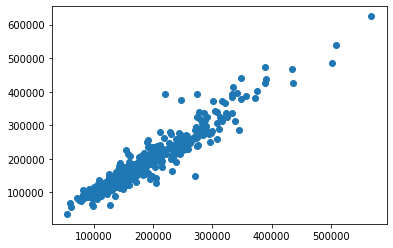

In [920]:
xgb_mse = mean_squared_error(ytest2_untrans, ypred2_xgb_untrans)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(ytest2_untrans, ypred2_xgb_untrans)

plt.scatter(ypred2_xgb_untrans, ytest2_untrans)
print('Mean Squared Error is', '{:,.2f}'.format(xgb_mse))
print('Root Mean Squared Error is', '{:,.2f}'.format(xgb_rmse))
print('Mean Absolute Error is', '{:,.2f}'.format(xgb_mae))

### Predicting the results using XGB

In [921]:
submit_pred_xgb = xgb.predict(test2)
submit_pred_xgb = pd.DataFrame(submit_pred_xgb, columns = ['SalePrice'])
submit_pred_untrans_xgb = pt.inverse_transform(submit_pred_xgb)

In [922]:
test_to_submit_ridge = pd.DataFrame(test['Id'])
test_to_submit_ridge['SalePrice'] = submit_pred_ridge_untrans
test_to_submit_ridge.to_csv('/content/predictions(xgb).csv', index=False)

## Try blending XGB and Lasso results

In [923]:
blend_las_weight = .9
ypred2_blend = ((1 - blend_las_weight) * ypred2_xgb_untrans) + (blend_las_weight * ypred2_las_untrans)

Mean Squared Error is 509,669,838.28
Root Mean Squared Error is 22,575.87
Mean Absolute Error is 14,376.54


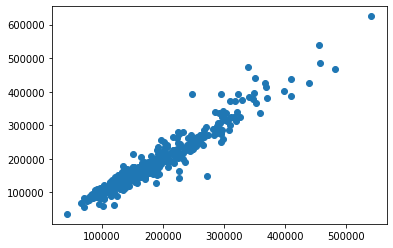

In [924]:
blend_mse = mean_squared_error(ytest2_untrans, ypred2_blend)
blend_rmse = np.sqrt(blend_mse)
blend_mae = mean_absolute_error(ytest2_untrans, ypred2_blend)

plt.scatter(ypred2_blend, ytest2_untrans)
print('Mean Squared Error is', '{:,.2f}'.format(blend_mse))
print('Root Mean Squared Error is', '{:,.2f}'.format(blend_rmse))
print('Mean Absolute Error is', '{:,.2f}'.format(blend_mae))

In [925]:
submit_blend_las_xgb = (submit_pred_untrans_xgb * (1-blend_las_weight)) + (submit_pred_untrans_las * blend_las_weight)

In [926]:
test_to_submit_blend = pd.DataFrame(test['Id'])
test_to_submit_blend['SalePrice'] = submit_blend_las_xgb
test_to_submit_ridge.to_csv('/content/predictions(blend).csv', index=False)

#Summarized RMSE results

In [927]:
print('{:,.2f}'.format(las_rmse), '- Lasso RMSE')
print('{:,.2f}'.format(ridge_rmse), '- Ridge RMSE')
print('{:,.2f}'.format(xgb_rmse), '- XGB RMSE')
print('{:,.2f}'.format(blend_rmse), '- Blend (Lasso/XGB) RMSE')

22,671.40 - Lasso RMSE
22,764.32 - Ridge RMSE
25,172.30 - XGB RMSE
22,575.87 - Blend (Lasso/XGB) RMSE
